In [14]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
from PIL import Image
import glob

In [15]:
filelist = glob.glob('data/pets/*.jpg')
#x_pets = np.asarray([np.asarray((Image.open(fname).resize((256,256)))) for fname in filelist])

x_pets = []
for file_name in filelist:
    img = Image.open(file_name).convert('RGB')
    img = img.resize((256,256))
    x_pets.append(np.array(img))


x_pets = np.asarray(x_pets)

In [33]:
filelist = glob.glob('data/vangogh/*.jpg')
x_vangogh = []
for file_name in filelist:
    img = Image.open(file_name).convert('RGB')
    img = img.resize((256,256))
    x_vangogh.append(np.array(img))


x_vangogh = np.asarray(x_pets)

IndexError: index 0 is out of bounds for axis 0 with size 0

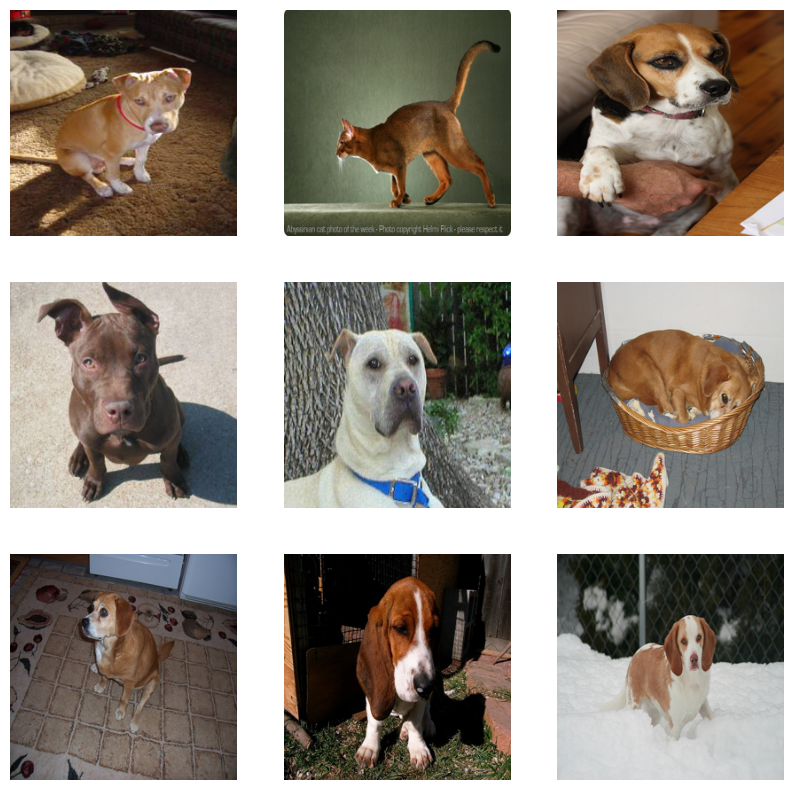

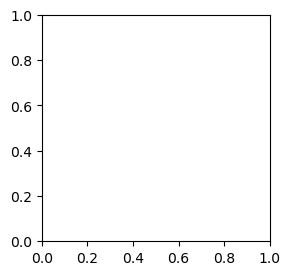

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(x_pets[i]).astype("uint8"))
    plt.axis("off")

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(x_vangogh[i]).astype("uint8"))
    plt.axis("off")

In [18]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.5
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

[[[253 253 253]
  [255 255 255]
  [229 231 226]
  ...
  [229 231 226]
  [255 255 255]
  [254 254 255]]

 [[255 255 255]
  [232 233 230]
  [ 89  94  83]
  ...
  [ 89  92  83]
  [233 234 231]
  [255 255 255]]

 [[254 254 253]
  [122 125 115]
  [ 42  48  30]
  ...
  [ 42  47  34]
  [123 126 117]
  [254 254 252]]

 ...

 [[254 254 253]
  [119 123 107]
  [ 35  42  24]
  ...
  [ 31  35  20]
  [116 119 110]
  [253 254 253]]

 [[255 255 255]
  [232 233 226]
  [ 83  86  73]
  ...
  [ 81  84  72]
  [231 232 230]
  [255 255 255]]

 [[254 253 255]
  [255 255 255]
  [228 229 224]
  ...
  [228 229 224]
  [255 255 255]
  [255 254 255]]]


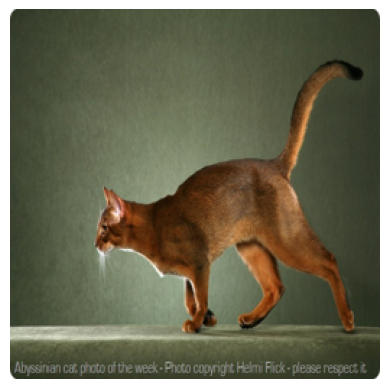

In [19]:
plt.imshow(x_pets[1])
plt.axis("off")
print(x_pets[1])

In [20]:
van_gogh_validator = keras.Sequential([
    layers.Input(shape=(None, None, 3)),
    layers.Conv2D(3, (1, 1), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Conv2D(1, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Reshape(target_shape=(1, 1)),
    layers.Dense(1, activation='sigmoid')
])
van_gogh_validator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, None, None, 3)     12        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, None, None, 3)    0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 128)   3584      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, None, None, 128)  0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, None, None, 64)  

In [37]:
transformer_pets_to_van_gogh = keras.Sequential([
    layers.Input(shape=(None,None,3)),
    layers.Dense(32, name='layer_dense'),
    layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same', name='first_conv2D'),
    layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same', name='second_conv2D'),
    layers.Conv2DTranspose(3, (3,3), strides=1, activation='relu', padding='same', name='third_conv2D'),
])
transformer_pets_to_van_gogh.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_dense (Dense)         (None, None, None, 32)    128       
                                                                 
 first_conv2D (Conv2DTranspo  (None, None, None, 32)   9248      
 se)                                                             
                                                                 
 second_conv2D (Conv2DTransp  (None, None, None, 64)   18496     
 ose)                                                            
                                                                 
 third_conv2D (Conv2DTranspo  (None, None, None, 3)    1731      
 se)                                                             
                                                                 
Total params: 29,603
Trainable params: 29,603
Non-trainable params: 0
__________________________________________________

In [27]:
# Générateur
transformer_pets_to_van_gogh.compile(loss="binary_crossentropy", optimizer="adam")
# Discriminator
van_gogh_validator.compile(loss="binary_crossentropy", optimizer="adam")

In [28]:
van_gogh_validator.trainable=False

z = keras.layers.Input(shape=(None,None,3))
image = transformer_pets_to_van_gogh(z)

valid = van_gogh_validator(image)

combined_network = keras.Model(z,valid)
combined_network.compile(loss='binary_crossentropy',optimizer='adam')


In [29]:
print(len(x_pets))

1165


1/1 [==============================] - 0s 449ms/step


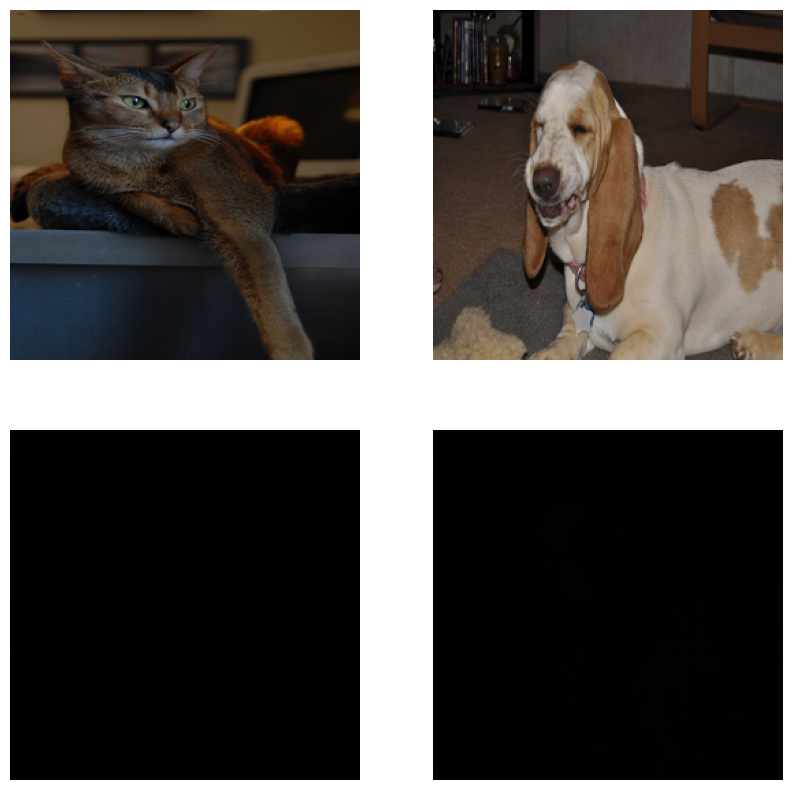

In [30]:
import random

def display_images():
    r, c = 2, 2

    index = np.random.randint(0, len(x_pets), c)
    pets_images = [x.tolist() for x in x_pets[index]]


    generated_images = transformer_pets_to_van_gogh.predict(pets_images)

    #Scaling the generated images
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=(10, 10))
    for i in range(c):
        ax = plt.subplot(r, c, i + 1)
        plt.imshow(np.array(pets_images[i]).astype("uint8"))
        plt.axis("off")

    for i in range(c):
        ax = plt.subplot(r, c, c + i + 1)
        plt.imshow(np.array(generated_images[i]).astype("uint8"))
        plt.axis("off")

    plt.show()
    plt.close()


display_images()

In [35]:
num_epochs = 5
batch_size = 1

valid = np.ones((256,256, 3))
fake = np.zeros((256,3))

display_interval = 1
valid = 0.05 * np.random.random(valid.shape)
fake = np.zeros((batch_size, 1))
fake += 0.05 * np.random.random(fake.shape)
for epoch in range(num_epochs):

    index = np.random.randint(0, len(x_pets), batch_size)
    pets_images = [x.tolist() for x in x_pets[index]]

    vangogh_index =  np.random.randint(0, x_vangogh.shape[0], batch_size)
    vangogh_images = [x for x in x_vangogh[vangogh_index]]

    generated_images = transformer_pets_to_van_gogh.predict(pets_images)
    discm_loss_fake = van_gogh_validator.train_on_batch(generated_images, fake)

    discm_loss_real = van_gogh_validator.train_on_batch(vangogh_images, valid)

    genr_loss=combined_network.train_on_batch(noise,valid)



    if epoch % display_interval == 0:
        print("EPOCH === ", epoch)
        print('Generator loss = ', genr_loss)
        print('Discriminator_loss = ', discm_loss_fake)
        display_images()


1/1 [==============================] - 0s 198ms/step


ValueError: in user code:

    File "/home/mithrandir/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/mithrandir/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mithrandir/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/mithrandir/miniconda3/lib/python3.9/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/home/mithrandir/miniconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "reshape_1" "                 f"(type Reshape).
    
    Cannot reshape a tensor with 4096 elements to shape [1,1,1] (1 elements) for '{{node sequential_2/reshape_1/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32](sequential_2/flatten_1/Reshape, sequential_2/reshape_1/Reshape/shape)' with input shapes: [1,4096], [3] and with input tensors computed as partial shapes: input[1] = [1,1,1].
    
    Call arguments received by layer "reshape_1" "                 f"(type Reshape):
      • inputs=tf.Tensor(shape=(1, 4096), dtype=float32)
